In [97]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [98]:
import numpy
import torch
import typing

from holo.prettyFormats import prettyPrint
from holo.__typing import assertIsinstance

In [99]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda:0


In [100]:
import handleDatas
import train
import basicModels
import MoE_models
import MoE_models.paper2
import modelsParameters

def cell():
    global handleDatas, train, MoE_models, basicModels, modelsParameters
    import importlib
    handleDatas = importlib.reload(handleDatas)
    train = importlib.reload(train)
    basicModels = importlib.reload(basicModels)
    modelsParameters = importlib.reload(modelsParameters)
    MoE_models.paper2 = importlib.reload(MoE_models.paper2)

cell();

In [ ]:
#datashandler = handleDatas.Cifar100_Datas(
#    fromTrainSource=None, maxSamples=None, trainProp=0.8,
#    batchSizeTrain=256, batchSizeTest=256)

datasHandler = handleDatas.HandleImagesClassifDatas.merge(
    #handleDatas.MNIST_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    #handleDatas.FashionMNIST_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    handleDatas.Cifar10_Datas(
        fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    #handleDatas.Cifar100_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    trainProp=0.8, batchSizeTrain=256, batchSizeTest=256)

loaded Cifar10(total: 60000), train: 48000 [188 batches] | test: 12000 [47 batches]
loaded Cifar100(total: 60000), train: 48000 [188 batches] | test: 12000 [47 batches]
loaded Merged[Cifar10, Cifar100](total: 120000), train: 96000 [375 batches] | test: 24000 [94 batches]


In [ ]:
model = moeModel = MoE_models.paper2.VisionModelMoe.get_cifar_v3(
    nbClasses=datasHandler.nbClasses, wImp=0.1, wLoad=0.1,
    nbExperts=2, topK=2, modelConfig="large").to(device)
lossFunc = torch.nn.CrossEntropyLoss().to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
hist = train.HistoryClassification()

#print(f"nbParams total: {basicModels.countTotalParameters(model.parameters()):_d}")
#basicModels.countLayersparameters(model)
modelsParameters.ModelTreeNode("Model", model).print(showTrainable=False, end=("experts", "gating", "Block_CNN"))

trainer = train.TrainerClassif_MoE2(model=model, optimizer=optim, criterion=lossFunc, device=device)

# test the model
_ = model(datasHandler.full_dataset[0]['image'].to(device)[None, ...].repeat((1, 1, 1, 1)))
#print(_[0].detach().cpu().numpy())
#print(_[1].detach().cpu().numpy())
#print(_[2].detach().cpu().numpy())

└── Model: 160_574 params
    └── blocks: 160_574 params
        ├── Block_CNN[0]: 432 params
        ├── Block_CNN[1]: 3_504 params
        ├── Block_FFD_Moe[2]: 114_672 params
        │   ├── gating: 1_200 params
        │   └── experts: 113_472 params
        ├── Block_CNN[3]: 6_912 params
        ├── Block_CNN[4]: 13_824 params
        ├── Dropout[5]: 0 params
        ├── Flatten[6]: 0 params
        └── Linear[7]: 21_230 params


In [107]:
trainer.train_model_classif(datasHandler=datasHandler, nbEpoches=3);

Epoch 1, train: (loss: 3.616, accuracy: 17.33%), test: (loss: 3.137, accuracy: 25.95%), lr: 2.0000e-03
Epoch 2, train: (loss: 2.992, accuracy: 28.30%), test: (loss: 2.822, accuracy: 31.69%), lr: 2.0000e-03
Epoch 3, train: (loss: 2.762, accuracy: 33.01%), test: (loss: 2.613, accuracy: 36.05%), lr: 2.0000e-03
{
    all: 100.00%,
    getBatch: 1.64%,
    predict+loss: 31.78%,
    backward: 54.63%,
    step: 2.34%,
    metrics_base: 0.32%,
    metrics_moe: 0.50%,
    evaluate: 7.78%,
    progressBar: 0.78%,
    other: 0.22%
}


In [111]:
print(("\n" + ' '*8).join(map(str, trainer.history)))
def cell():
    bestTrain = trainer.history[max(range(len(trainer.history)), key=lambda i:trainer.history[i].train.accuracy())]
    bestTest = trainer.history[max(range(len(trainer.history)), key=lambda i:trainer.history[i].test.accuracy())]
    print(' ' * 4 + f"-> best accuracy, train: {bestTrain.train.accuracy():.2%} (epoch {bestTrain.epochID}), "
          f"test: {bestTest.test.accuracy():.2%} (epoch {bestTest.epochID})")
cell(); del cell

Epoch 1, train: (loss: 3.616, accuracy: 17.33%), test: (loss: 3.137, accuracy: 25.95%), lr: 2.0000e-03
        Epoch 2, train: (loss: 2.992, accuracy: 28.30%), test: (loss: 2.822, accuracy: 31.69%), lr: 2.0000e-03
        Epoch 3, train: (loss: 2.762, accuracy: 33.01%), test: (loss: 2.613, accuracy: 36.05%), lr: 2.0000e-03
    -> best accuracy, train: 33.01% (epoch 3), test: 36.05% (epoch 3)


In [115]:
def cell():
    with numpy.printoptions(threshold=100_000, linewidth=100_000):
        htest2 = assertIsinstance(train.Moe2ExpertsInsigths, trainer.history[-1].test.moeExpertsInsigths)
        for htest in htest2.expertsInsigths:
            nbExperts = htest.sumExpertsGate.shape[0]
            print(f"-> RESULT")
            a: numpy.ndarray = htest.meanExpertsGate()
            b: numpy.ndarray = htest.meanPredClassesExpertsGate().std(axis=0)
            print(f"mean: {a.round(3)} (std: {a.std(axis=0).round(3)})")
            print(f"std: {b.round(3)} (mean: {b.mean().round(3)})")
            print(f"perClassPred: \n{htest.meanPredClassesExpertsGate().round(2).T}")
            print("\n")
        
        rnd = 2
        htests: list[list] = [] # list per MoE of list of htest
        htrains: list[list] = [] # list per MoE of list of htrain
        for i, h in enumerate(trainer.history):
            htest2 = assertIsinstance(train.Moe2ExpertsInsigths, h.test.moeExpertsInsigths)
            htrain2 = assertIsinstance(train.Moe2ExpertsInsigths, h.train.moeExpertsInsigths)
            for i2, (htest, htrain) in enumerate(zip(htest2.expertsInsigths, htrain2.expertsInsigths)):
                if i == 0:
                    htests.append([htest])
                    htrains.append([htrain])
                else: 
                    htests[i2].append(htest)
                    htrains[i2].append(htrain)
        for moe_htrains, moe_htests in zip(htrains, htests):
            for epoch, (htrain, htest) in enumerate(zip(moe_htrains, moe_htests), start=1):
                print(" ->", epoch)
                #print(htest.nbPred.round(rnd))
                #print(htest.nbTruth.round(rnd))
                print("delta (nbPred-nbTruth) per class[test]:\n ", (htest.nbPred - htest.nbTruth), sep="")
                print("mean experts use[train]: ", htrain.meanExpertsGate().round(rnd), sep="")
                print("mean experts use[test]: ", htest.meanExpertsGate().round(rnd), sep="")
                print("mean experts use per class predicted [test]:\n", htest.meanPredClassesExpertsGate().round(rnd).T, sep="")
                print("std experts use acros classes [test]:\n ", htest.meanPredClassesExpertsGate().std(axis=0).round(rnd), sep="")
                #print(htest.meanTruthClassesExpertsGate().round(rnd).T)
                #print((htest.meanPredClassesExpertsGate() - htest.meanTruthClassesExpertsGate()).round(rnd).T)
                print()
    

cell(); del cell

-> RESULT
mean: [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf] (std: nan)
std: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] (mean: nan)
perClassPred: 
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

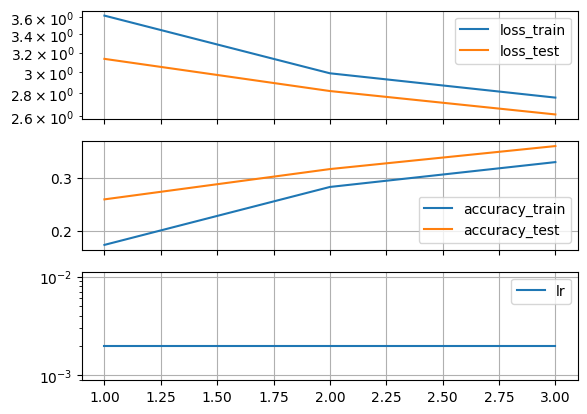

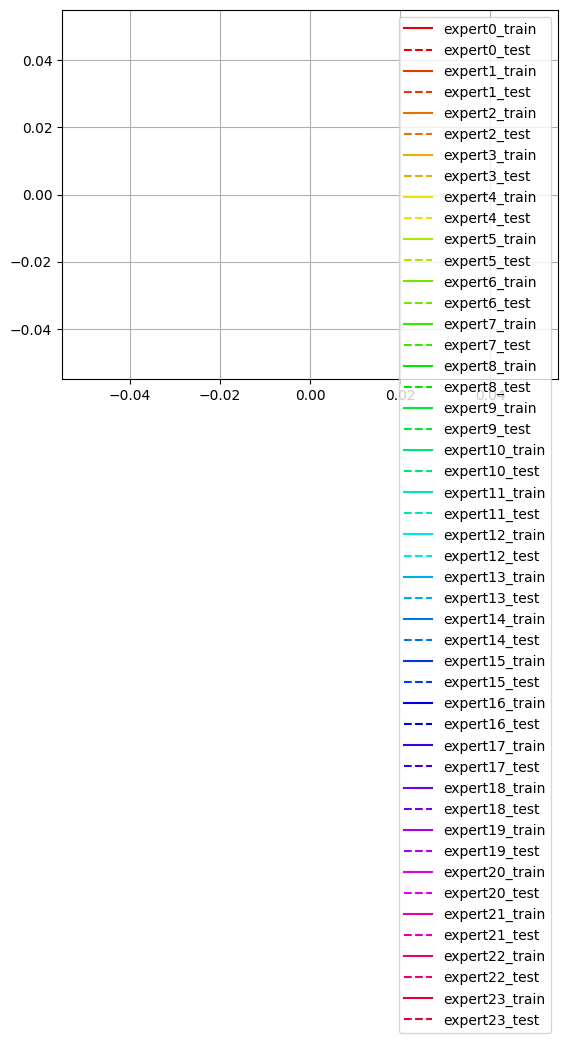

In [116]:
trainer.history.plot()
trainer.history.plotMoe2Insigths()

In [117]:
def cell():
    conf = trainer.history[-1].test.confusionMatrix
    #print(conf.matrix[0, :].T)
    #print(conf.matrix[65, 65], conf.matrix[65, :])
    
    with numpy.printoptions(threshold=100_000, linewidth=100_000):
        print(conf.matrix)
    print()

    for clsIndex in range(datasHandler.nbClasses):
        print(f"class: {clsIndex}, precision:{conf.classPrecision(clsIndex):.2%}, "
              f"hitRate: {conf.classHitRate(clsIndex):.2%}")
    print()
    
    prettyPrint(conf.worstK_confusions(10), 
                specificCompact={tuple}, specificFormats={numpy.float64:lambda x:f"{x:.4g}"})
cell(); del cell

[[805  32 165  40  63  28  24  20 168  69   0   4   5   4   5   8   2  12  19   5   3   4  22   3   4   4   5   7   9   4  15   2  11   8  49  10   7   9  12  18  32   2   6   4   2   1   2   5   5  20  23  25   1   0  12  13   2   3   6  17   8   2   1   1   3  24  13   4   4   7   3   3   2   2   3   4   2  16  21   9   5  13  17  19   7   7   1  10  10  18   2  12   2   2   9  10  11   6   1   6  23  16   3  10   0  64   2   3   3  19]
 [ 39 826  17   7   6   7  18   5  50 123   6   7   0   1   3   6   0   2   5   2   3   8   6  34   6   0   5   0   1   0   2   5   9   0   0   4   3   5   1   1   1   0   1   1   0   1   0   0   1   6   6   5   4   0   1   2   0   1  14   0   1   3   0   2   2   3   1   0  64   0   0   2   1   0   1   0   3   0   0   0   3   0   1   3   1   9   1   2   6   0   0  22   0   2   5  12   7   4   1   3   9  14   3   4   1   1   0   4   2   2]
 [ 21   1 430 101 123  79  55  28   9   9   0   2   7   6  17   7  13  22  14  11   3   5   2   0  15   3   7   1 

ZeroDivisionError: division by zero

In [ ]:
import winsound
winsound.Beep(200, 300)  # frequency in Hz, duration in ms